In [1]:
import csv
import cv2
import numpy as np


In [2]:
lines = []
samples = []
with open('driving_log_1.csv') as cscfile:
    reader = csv.reader(cscfile)
    for line in reader:
        lines.append(line)
        samples.append(line)
images = []
measurements = []
for line in lines:
    #for i in range(3):
    source_path= line[0]
    image = cv2.imread(source_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)


X_train = np.array(images)
y_train = np.array(measurements)

In [3]:
print(len(images))
print(len(measurements))

12927
12927


In [3]:
# Data augmentation
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)
    
# convert images and measurement to NumPy arrays, since the format Keras requires.
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

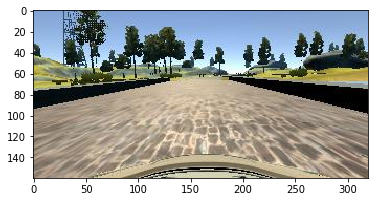

In [20]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(augmented_images[1])

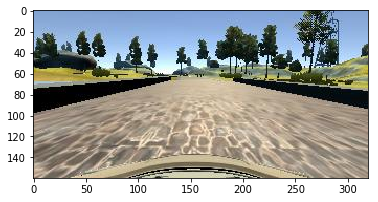

In [18]:
plt.imshow(images[1])

In [5]:
import os

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import sklearn
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB) 
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)
#X_train_generator, y_train_generator = generator(train_samples, batch_size=32)
#X_validation_generator, y_validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 66, 200  # Trimmed image format

In [8]:
# Convolution neural network block
# Build the Neural Network, (flattened image connected to a single output node)
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout,Cropping2D
#from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Convolution2D, Lambda
#from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dropout


model = Sequential()
# Normalization
model.add(Lambda(lambda x: (x/127.5) - 1., input_shape=(160,320,3)))
#model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row, col, ch),output_shape=(row, col, ch)))
# LeNet()
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# checkpoint
# from keras.callbacks import ModelCheckpoint
# filepath="weights-curr-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
# callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator, samples_per_epoch =len(train_samples), validation_data = validation_generator,nb_val_samples = len(validation_samples), nb_epoch=3, verbose=1)
model.save('model2.h5')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The semantics of the Keras

Epoch 1/3
10341/10341 [==============================] - 1391s - loss: 0.0032 - val_loss: 0.0104
Epoch 2/3
10341/10341 [==============================] - 1288s - loss: 6.8011e-04 - val_loss: 0.0093
Epoch 3/3
10341/10341 [==============================] - 1224s - loss: 4.9540e-04 - val_loss: 0.0099


['loss', 'val_loss']


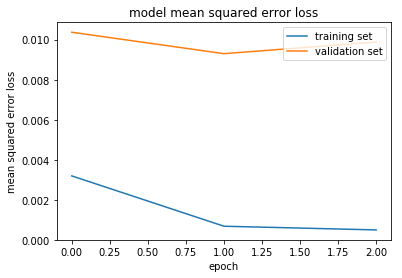

In [9]:
import matplotlib.pyplot as plt


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
print(train_samples)